In [1]:
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

In [2]:
image_dir = 'drive/MyDrive/archive/images'
annotation_dir = 'drive/MyDrive/archive/annotations'

In [3]:
imgs_name_list = list(sorted(os.listdir(image_dir)))
annos_name_list = list(sorted(os.listdir(annotation_dir)))

df_imgs_annos = pd.DataFrame({'imgs': imgs_name_list, 'annos': annos_name_list})
df_imgs_annos.head()

,imgs,annos
0,maksssksksss0.png,maksssksksss0.xml
1,maksssksksss1.png,maksssksksss1.xml
2,maksssksksss10.png,maksssksksss10.xml
3,maksssksksss100.png,maksssksksss100.xml
4,maksssksksss101.png,maksssksksss101.xml


In [4]:
# Sort images and annotations by their file name.
df_imgs_annos.index = df_imgs_annos['imgs'].apply(lambda x: int(re.search(r'[0-9]+', x)[0]))
df_imgs_annos = df_imgs_annos.sort_index()
df_imgs_annos.head()

,imgs,annos
imgs,,
0,maksssksksss0.png,maksssksksss0.xml
1,maksssksksss1.png,maksssksksss1.xml
2,maksssksksss2.png,maksssksksss2.xml
3,maksssksksss3.png,maksssksksss3.xml
4,maksssksksss4.png,maksssksksss4.xml


In [5]:
# Split dataset for train and test.
df_imgs_annos_tr = df_imgs_annos[:800]
df_imgs_annos_te = df_imgs_annos[800:]

In [6]:
def _generate_box(obj):
  '''xmlの要素からbboxを取得'''
  xmin = int(obj.find('xmin').text)
  ymin = int(obj.find('ymin').text)
  xmax = int(obj.find('xmax').text)
  ymax = int(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

def _generate_label(obj):
  '''xmlの要素からlabelを取得'''
  if obj.find('name').text == "with_mask":
    return 1
  elif obj.find('name').text == "mask_weared_incorrect":
    return 2
  return 0 # background class

def generate_target(image_id, file):
  with open(file, 'r') as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')

    num_obj = len(objects)

    boxes = []
    labels = []
    for obj in objects:
      boxes.append(_generate_box(obj))
      labels.append(_generate_label(obj))
    # We should convert varilable to type of torch.Tensor()
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    labels = torch.as_tensor(labels, dtype=torch.int64)
    image_id = torch.tensor([image_id])
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id

    return target

In [7]:
class MaskDataset(object):
  def __init__(self, df_imgs_annos, transforms):
    self.transforms = transforms
    self.df_imgs_annos = df_imgs_annos
  
  def __len__(self):
    # return len(self.images)
    return len(self.df_imgs_annos)

  def __getitem__(self, idx):
    '''idx情報を使用して、imgとtarget(label)を返す'''
    image_name = self.df_imgs_annos.loc[idx, 'imgs']
    labels_name = self.df_imgs_annos.loc[idx, 'annos']
    # image_dir = 'drive/MyDrive/archive/images'
    # annotation_dir = 'drive/MyDrive/archive/annotations'
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(annotation_dir, labels_name)
    img = Image.open(image_path).convert("RGB")

    target = generate_target(idx, label_path) # bbox, labels
    if self.transforms is not None:
      img = self.transforms(img)
    return img, target

In [8]:
data_transforms = transforms.Compose([
      transforms.ToTensor(),                             
])

In [9]:
def collate_fn(batch):
  return tuple(zip(*batch))

dataset = MaskDataset(df_imgs_annos_tr, data_transforms)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn
)

In [5]:
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # replace the pre-trained head
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [11]:
# Check if GPU is active or not.
torch.cuda.is_available()

True

## Train

In [12]:
model = get_model(num_classes=3)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# dataloaderが正常に動作しているかを確認
for imgs, annos in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annos = [{k: v.to(device) for k, v in target.items()} for target in annos]
  print(f'imgs size: {len(imgs)}')
  print(imgs[0].shape)

  print(f'annos size: {len(annos)}')
  print(annos[0].keys())
  print(annos[0]['boxes'].shape)
  break

imgs size: 4
torch.Size([3, 366, 512])
annos size: 4
dict_keys(['boxes', 'labels', 'image_id'])
torch.Size([3, 4])


In [14]:
num_epochs = 25
# num_epochs = 10 
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  model.train()
  counter = 0
  epoch_loss = 0
  # for i, imgs, annotations in enumerate(tqdm(data_loader)):
  for imgs, annotations in tqdm(data_loader):
    counter += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model([imgs[0]], [annotations[0]])
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if counter % 100 == 0:
      print(f'Iteration: {counter}/{len_dataloader}, Loss: {losses}')
    epoch_loss += losses
  print(epoch_loss)


 50%|█████     | 100/200 [06:23<07:16,  4.37s/it]

Iteration: 100/200, Loss: 0.42536213994026184


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.6590861082077026
tensor(81.9853, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:30<00:34,  2.91it/s]

Iteration: 100/200, Loss: 0.4105970859527588


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.4462718069553375
tensor(53.6098, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.91it/s]

Iteration: 100/200, Loss: 0.21081288158893585


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.4775071442127228
tensor(52.7216, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.19412988424301147


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.31801435351371765
tensor(41.1610, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.13841867446899414


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.2591002583503723
tensor(35.8242, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.17701227962970734


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.2507660686969757
tensor(31.6474, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.2384827733039856


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.3077113926410675
tensor(32.0527, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.1869274079799652


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.35215842723846436
tensor(29.9926, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.11923300474882126


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.3252336084842682
tensor(29.6403, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.95it/s]

Iteration: 100/200, Loss: 0.1737259328365326


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.32586973905563354
tensor(29.3483, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.95it/s]

Iteration: 100/200, Loss: 0.1861291378736496


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.3211781978607178
tensor(29.2302, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.1854696422815323


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.24891522526741028
tensor(25.5935, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.1343110352754593


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.24565139412879944
tensor(22.7764, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.21932169795036316


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.23013903200626373
tensor(22.9893, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.10000275820493698


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.2650524079799652
tensor(23.1849, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.92it/s]

Iteration: 100/200, Loss: 0.1882224977016449


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.2603550851345062
tensor(23.3150, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.10319706052541733


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.23606500029563904
tensor(21.2643, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.94it/s]

Iteration: 100/200, Loss: 0.06635145843029022


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.23039954900741577
tensor(19.1401, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.94it/s]

Iteration: 100/200, Loss: 0.07708083838224411


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.1997758448123932
tensor(21.7272, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.96it/s]

Iteration: 100/200, Loss: 0.1340242624282837


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.22475513815879822
tensor(22.2219, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:34,  2.93it/s]

Iteration: 100/200, Loss: 0.1177382618188858


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.18020685017108917
tensor(19.7770, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.94it/s]

Iteration: 100/200, Loss: 0.12429739534854889


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.18084129691123962
tensor(17.4090, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.94it/s]

Iteration: 100/200, Loss: 0.08972936868667603


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.1811181902885437
tensor(17.2546, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.96it/s]

Iteration: 100/200, Loss: 0.11111472547054291


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 200/200, Loss: 0.21626096963882446
tensor(17.0196, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [00:29<00:33,  2.94it/s]

Iteration: 100/200, Loss: 0.0796298012137413


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]

Iteration: 200/200, Loss: 0.25099843740463257
tensor(18.4515, device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
model_save_path = 'drive/MyDrive/archive/model2.pt'

# Be carefull to overwirte saved model by not trained model.
# for gpu inference
# torch.save(model.state_dict(), model_save_path)

# for cpu inference
# torch.save(loaded_model.to('cpu').state_dict(), model_save_cpu_path)

## Inference

In [6]:
loaded_model = get_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [19]:
model_save_path = 'drive/MyDrive/archive/model2.pt'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
loaded_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [31]:
# cv2
# img = cv2.imread(imgfile)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# image_tensor = torchvision.transforms.functional.to_tensor(img)

img = Image.open(
    '/content/drive/MyDrive/archive/images/maksssksksss850.png').convert("RGB")
img = data_transforms(img) # to torch.Tensor()
print(img.shape)

torch.Size([3, 200, 400])


In [32]:
with torch.no_grad():
  # model input shuld be list of images
  preds = loaded_model([img.to(device)])

In [33]:
preds

[{'boxes': tensor([[146.3129,  33.3476, 172.8577,  62.7437],
          [323.8776,  49.6877, 349.9117,  78.7702],
          [ 44.9269,  52.1530,  62.3962,  80.9184]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9989, 0.9985, 0.9975], device='cuda:0')}]

In [34]:
def plot_img_with_annos(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

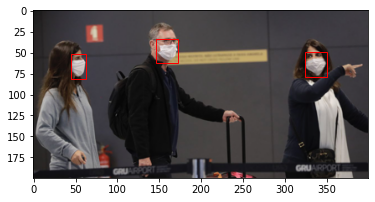

In [35]:
plot_img_with_annos(img, preds[0])
# plot_image_with_annos(img_single[0], preds[0])

In [192]:
# save as png
# plt.savefig('../media/figure_with_annos.png') # -----(2)